In [1]:
# import python packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from iteround import saferound

# matplotlib magic command to make sure plots appear inline
%matplotlib inline

# set seaborn colour codes and palette
sns.set(color_codes=True)
sns.set_palette("Set2");

In [2]:
# import truncted norm form scipy
from scipy.stats import truncnorm

# truncated norm function https://stackoverflow.com/a/44308018
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

# Premise of Notebook

Home-field advantage is a long acknowleged phenomenon in football. While there is empirical evidence for this phenomenon, there is little understanding of the underlying factors that cause it. This notebook will attempt to randomly generate league data for teams based on factors determined by real world data. Data will be analysed and generated across six variables: goals scored at home, goals conceded at home, points gained at home, goals scored away from home, goals conceded away from home, and points gained away from home. I will first analyse real world data for the 2018/19 season of the English Premier League in order to establish teams performance at home and away from home. The dataset used is an existing dataset that I had created based on the results of the last Premier League season.

Teams' performance at home tends to be better than their performance away from home, scoring more goals, and conceding less, leading to more points gained. Initial analysis will be carried out on the dataset, examining the goals scored and conceded, goal difference, and points gained at home and away from home.

When that analysis has been completed random data will be generated, using the numpy package, to simulate a league table with those variables.

# Methodology

Home and away league tables are available [here](https://www.soccerstats.com/homeaway.asp?league=england_2019). Viewing these tables as far back as the 2011/12 season supports the fact that teams perform better at home. For example, the 2018/19, which will be the my basis for generating random data, all but one team(Crystal Palace) gained more points per game at home than away.

The first variables that will be examined are the goals scored and conceded at home. The real world values will be used to calculate attacking and defensive coefficients than can be used as parameters when genereting random data. The goals scored and conceded away from home will be generated in much the same way; however this data will have to be normalised so that it is equal to thwe number of goals scored and conceded at home.

Finally, the distribution of points across the league will be established. Once a suitable distribution is identiifed it can be used to generate point totals for teams.

# 1. Real World Data

In [3]:
# imported csv 
pl = pd.read_csv("league_table.csv", index_col="Team", names=["Team", "Home(F)", "Home(A)", "Points(H)", "Away(F)", "Away(A)", "Points(A)" ]);

In [4]:
# added new column of total goals scored
pl["Total(F)"] = pl["Home(F)"] + pl["Away(F)"]
# added new column of total goals conceded
pl["Total(A)"] = pl["Home(A)"] + pl["Away(A)"]
# added new column of difference between goals scored and conceded
pl["Total(Dif)"]= pl["Total(F)"] - pl["Total(A)"]
# added new column with total points
pl["Total(P)"] = pl["Points(H)"] + pl["Points(A)"]

# created dataframe with total goals for, against, difference, and total points
total = pl[["Total(F)", "Total(A)", "Total(Dif)", "Total(P)"]]
total = total.sort_values(by = "Total(P)", ascending=False);
total

,Total(F),Total(A),Total(Dif),Total(P)
Team,,,,
Manchester City,95,23,72,98
Liverpool,89,22,67,97
Chelsea,63,39,24,72
Tottenham,67,39,28,71
Arsenal,73,51,22,70
Manchester United,65,54,11,66
Wolves,47,46,1,57
Everton,54,46,8,54
Leicester City,51,48,3,52


The original dataset only contains data seperated by home and away tables. As such, a combined dataframe was created. This dataframe will used as a reference point for the randomly generated league table.

In [5]:
# description of total table
total.describe()

,Total(F),Total(A),Total(Dif),Total(P)
count,20.000000,20.000000,20.000000,20.000000
mean,53.600000,53.600000,0.000000,53.450000
std,18.071204,15.752694,32.371202,21.007455
min,22.000000,22.000000,-54.000000,16.000000
25%,44.250000,46.000000,-20.750000,39.750000
50%,51.500000,53.500000,-2.500000,51.000000
75%,63.500000,65.750000,13.750000,67.000000
max,95.000000,81.000000,72.000000,98.000000


This data will may be useful later as a point of comparison to the randomly generated data. This one thing that jumps out as a factor than needs to be consideder; the mean goal difference is 0. This makes sense, all the goals scored must correspond to a goal conceded by another team. Therefore, when generating away goal data it will be import to normalise the data so that it equals its corresponding random home value.

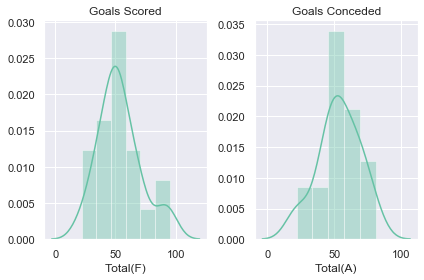

In [6]:
# distibution of goals scored at home across the league
plt.subplot(1,2,1)
sns.distplot(total["Total(F)"])
plt.title("Goals Scored");

# distribution of goals conceded at home across the league
plt.subplot(1,2,2)
sns.distplot(total["Total(A)"])
plt.title("Goals Conceded");

plt.tight_layout()

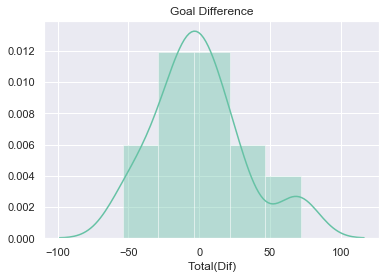

In [7]:
# distribution of goal difference
sns.distplot(total["Total(Dif)"])
plt.title("Goal Difference");

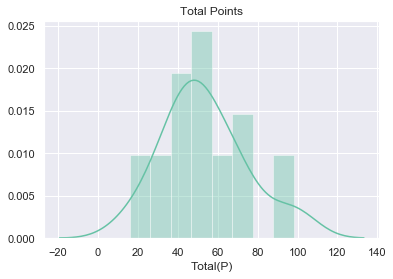

In [8]:
# distribution of total points
sns.distplot(total["Total(P)"], bins=8)
plt.title("Total Points");

The distribution of points seems to follow a normal(gaussian) distribution. This can be confirmed by running a [Shapiro-Wilk test](https://en.wikipedia.org/wiki/Shapiro–Wilk_test), which test whether samples came from a normal distribution.

In [9]:
# https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

from scipy.stats import shapiro

stat, p = shapiro(total["Total(P)"])

alpha = 0.05

if p > alpha:
    print("Points Distribution appears to be Gaussian")
else:
    print("Points distribution does not appear to be Gaussian")

Points Distribution appears to be Gaussian


This means that a normal distribution in numpy can be used to generate a teams points total.

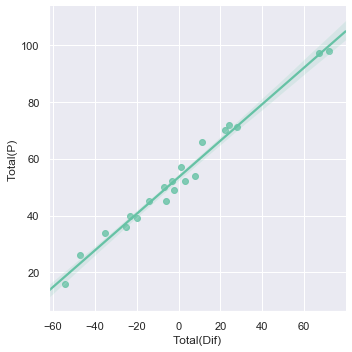

In [10]:
# regression plot between goal difference and total points
sns.lmplot(x="Total(Dif)", y="Total(P)", data=total);

There is a strong correlation between a team's goal difference and total points. Once random goal data has been generated for all teams, the goal difference may be used as the order in which to assign the points to teams.

## Home

In [11]:
# added new column with home goal difference
pl["Home(Dif)"] = pl["Home(F)"] - pl["Home(A)"]
# created league table based on home form
home = pl[["Home(F)", "Home(A)", "Home(Dif)", "Points(H)"]]
# sorted league table by points
home = home.sort_values(by = "Points(H)", ascending=False);
home

,Home(F),Home(A),Home(Dif),Points(H)
Team,,,,
Manchester City,57,12,45,54
Liverpool,55,10,45,53
Arsenal,42,16,26,45
Chelsea,39,12,27,42
Tottenham,34,16,18,38
Manchester United,33,25,8,36
Wolves,28,21,7,34
Everton,30,21,9,34
West Ham,32,27,5,31


In [12]:
# description of home stats
home.describe()

,Home(F),Home(A),Home(Dif),Points(H)
count,20.000000,20.000000,20.000000,20.000000
mean,29.800000,23.800000,6.000000,30.700000
std,11.542142,7.878017,18.381913,11.494163
min,10.000000,10.000000,-21.000000,9.000000
25%,23.500000,19.000000,-5.000000,23.000000
50%,27.500000,25.000000,4.500000,28.000000
75%,33.250000,28.500000,11.250000,36.500000
max,57.000000,38.000000,45.000000,54.000000


## Away

In [13]:
# added new column with away goal difference
pl["Away(Dif)"] = pl["Away(F)"] - pl["Away(A)"]
# created league table based on away form
away = pl[["Away(F)", "Away(A)", "Away(Dif)", "Points(A)"]]
# sorted league table by points
away = away.sort_values(by="Points(A)", ascending=False);
away

,Away(F),Away(A),Away(Dif),Points(A)
Team,,,,
Manchester City,38,11,27,44
Liverpool,34,12,22,44
Tottenham,33,23,10,33
Chelsea,24,27,-3,30
Manchester United,32,29,3,30
Crystal Palace,32,30,2,29
Leicester City,27,28,-1,25
Arsenal,31,35,-4,25
Watford,26,31,-5,23


In [14]:
# description of away stats
away.describe()

,Away(F),Away(A),Away(Dif),Points(A)
count,20.000000,20.000000,20.000000,20.000000
mean,23.800000,29.800000,-6.000000,22.750000
std,7.831112,9.225822,15.245362,10.361238
min,12.000000,11.000000,-33.000000,5.000000
25%,18.000000,25.000000,-16.250000,16.000000
50%,24.000000,29.500000,-5.000000,22.000000
75%,31.250000,35.000000,-0.250000,29.250000
max,38.000000,45.000000,27.000000,44.000000


## Home vs. Away

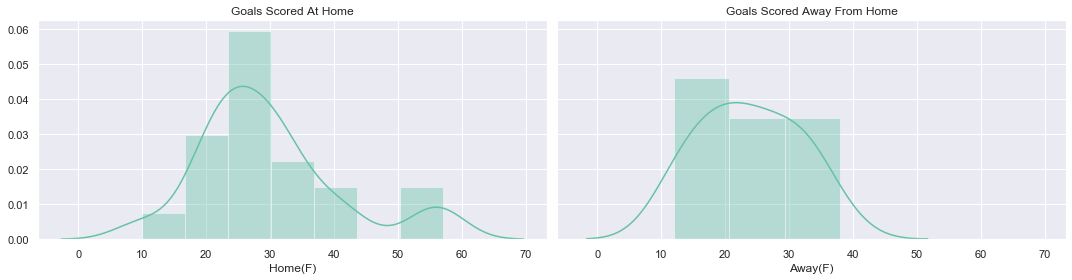

In [15]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharex=True, sharey=True)

# distribution of goals scored at home
sns.distplot(home["Home(F)"], ax=axes[0])
axes[0].set_title("Goals Scored At Home");

# distibution of goals scored away from home across the league
sns.distplot(away["Away(F)"], ax= axes[1])
axes[1].set_title("Goals Scored Away From Home");

plt.tight_layout()



There is a marked difference between the number, and distribution, of goals scored at home and away from home. This difference will have to be accounted for when generating random data for goals scored.

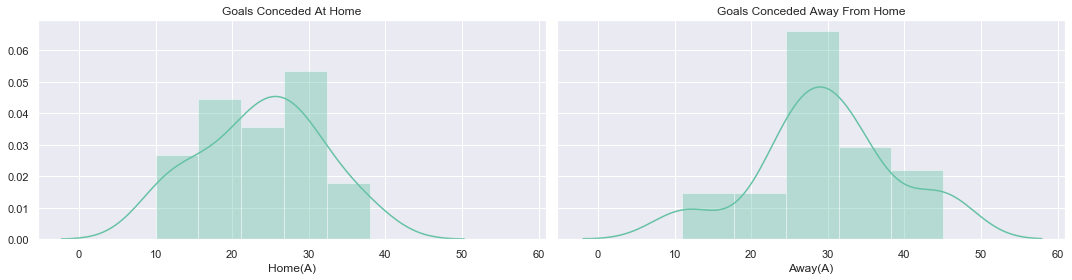

In [16]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharex=True, sharey=True)

# distribution of goals conceded at home
sns.distplot(home["Home(A)"], ax=axes[0])
axes[0].set_title("Goals Conceded At Home");

# distibution of goals conceded away from home 
sns.distplot(away["Away(A)"], ax= axes[1])
axes[1].set_title("Goals Conceded Away From Home");

plt.tight_layout()


This difference is also visible when it comes to goals conceded.

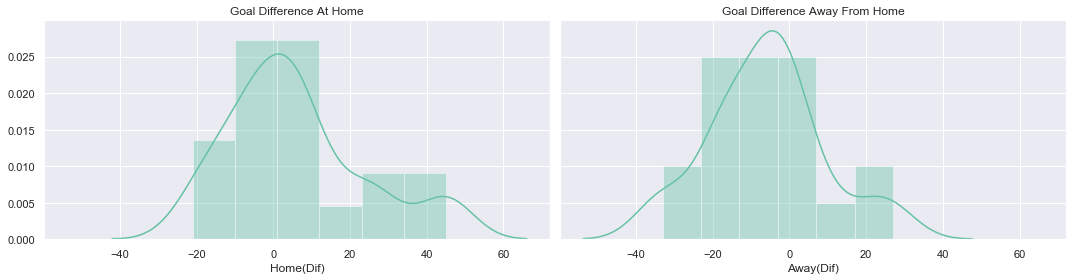

In [17]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True, sharex=True)

# distribution of goals difference at home
sns.distplot(home["Home(Dif)"], ax=axes[0])
axes[0].set_title("Goal Difference At Home");

# distibution of goals difference away from home 
sns.distplot(away["Away(Dif)"], ax= axes[1])
axes[1].set_title("Goal Difference Away From Home");

plt.tight_layout()


Logically, it follows that this difference is evident when viewing goal difference at home and away from home.

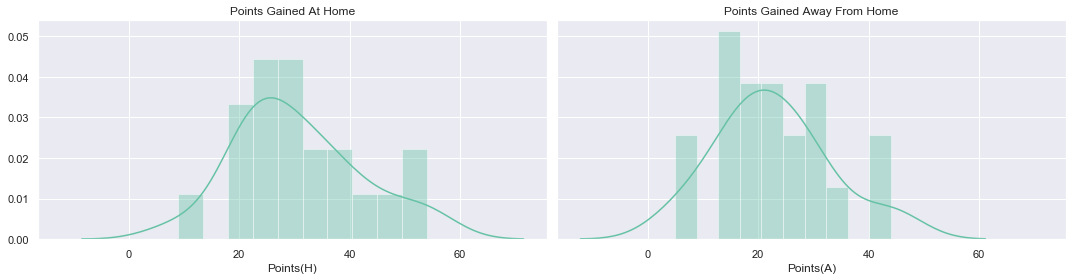

In [18]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True, sharex=True)

# distribution of goals scored at home
sns.distplot(home["Points(H)"], bins= 10, ax=axes[0])
axes[0].set_title("Points Gained At Home");

# distibution of goals scored away from home across the league
sns.distplot(away["Points(A)"], bins= 10, ax= axes[1])
axes[1].set_title("Points Gained Away From Home");

plt.tight_layout()


The points gained at home higher and have a greater density at the higher numbers also.

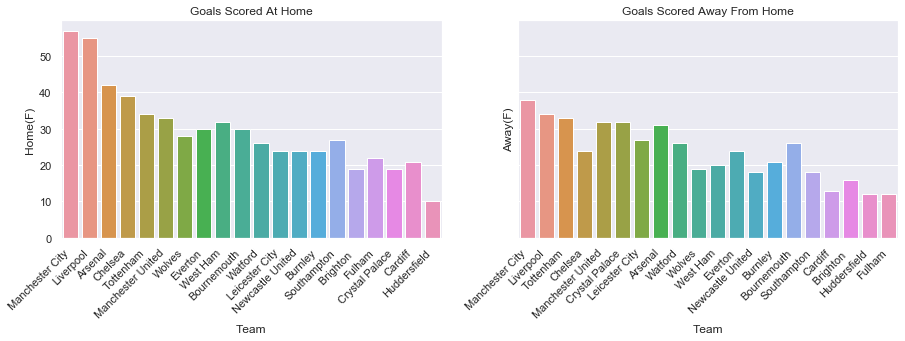

In [19]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# distribution of goals scored at home
goals_for = sns.catplot(x="Team", y="Home(F)", kind="bar", data=home.reset_index(), ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[0].set_title("Goals Scored At Home");

# distibution of goals scored away from home 
goals_for = sns.catplot(x="Team", y="Away(F)", kind="bar", data=away.reset_index(), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[1].set_title("Goals Scored Away From Home");

plt.tight_layout()

# closed empty plots
plt.close(2)
plt.close(3)

Here, we can see that most teams score less goals away from home with few exceptions.

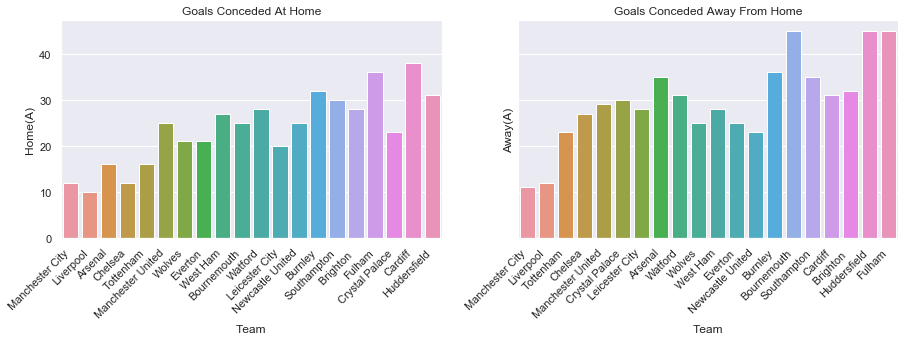

In [20]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# distribution of goals conceded at home
goals_for = sns.catplot(x="Team", y="Home(A)", kind="bar", data=home.reset_index(), ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[0].set_title("Goals Conceded At Home");

# distibution of goals conceded away from home 
goals_for = sns.catplot(x="Team", y="Away(A)", kind="bar", data=away.reset_index(), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[1].set_title("Goals Conceded Away From Home");

plt.tight_layout()

# closed empty plots
plt.close(2)
plt.close(3)

The same is also true of goals conceded.

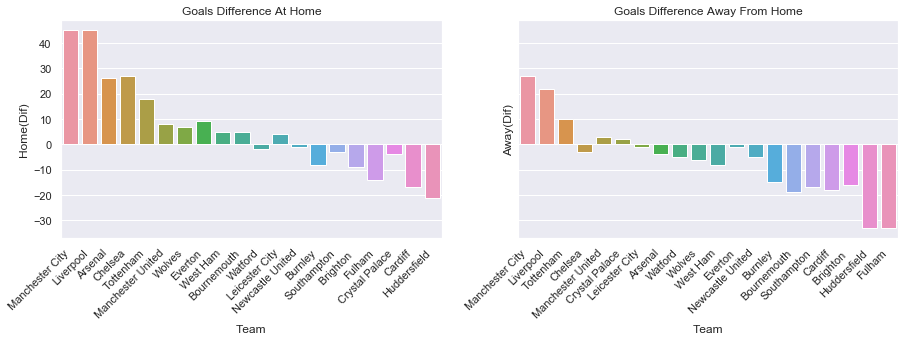

In [21]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# distribution of goal difference at home
goals_for = sns.catplot(x="Team", y="Home(Dif)", kind="bar", data=home.reset_index(), ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[0].set_title("Goals Difference At Home");

# distibution of goal difference away from home 
goals_for = sns.catplot(x="Team", y="Away(Dif)", kind="bar", data=away.reset_index(), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[1].set_title("Goals Difference Away From Home");

plt.tight_layout()

# closed empty plots  
plt.close(2)
plt.close(3)

This is further evident when viewing goal difference, with far more teams having a minus goal difference away from home.

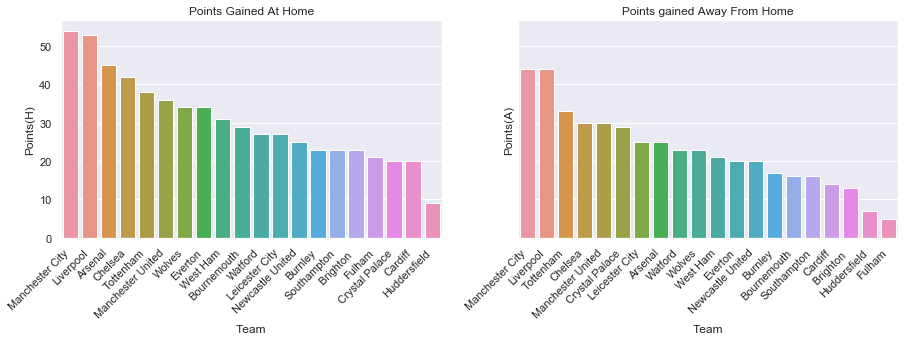

In [22]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# bar plot of points gained at home
goals_for = sns.catplot(x="Team", y="Points(H)", kind="bar", data=home.reset_index(), ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[0].set_title("Points Gained At Home");

# bar plot of points gained away from home 
goals_for = sns.catplot(x="Team", y="Points(A)", kind="bar", data=away.reset_index(), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[1].set_title("Points gained Away From Home");

plt.tight_layout()

# closed empty plots
plt.close(2)
plt.close(3)

And again we can see that almost all times have accumulated less points away from home.

## Characteristics To Consider When Generating Random Data

Due to marked difference between home and away form the random data will be generated under different parameters for home and away before being combined into a total table at the end. Each team will be assigned an attacking coefficient based on the number of goals scored at home divided by the number of games played at home. This number will then be divided by the average number of home goals score per game across the league. This coefficient will be used as a parameter when generating the number of goals scored by each team.

A defensive coefficient will similarily be assigned based on the number of goals conceded by a team at home divided by the number of games played at home. This number will then be divided by the average number of goals conceded per game across the team.

The same model will then be applied to a team's away data. Once random goal data has been generated, each team's goal difference will be calculated. As noted previously, a higher goal difference correlates with a higher points total. As such, once points have been randomly generated for each team they will be assigned based on goal difference.

## numpy.random distribution

Upon researching different distributions available in numpy for generating random data it was decided the the poisson distribution was the most suitable. The poisson distribution accepts two inputs; lam, the expection of interval, and the size of the output. The coefficients mentioned in the previous section can be used to generate the lam values and the output size will be the number of teams in the league.

In [23]:
# example
np.random.poisson(lam=(10,25,19,13,33,23,11,34,21,31,11,22,33,44,55,12,17,8,15,5), size=(20))

array([ 9, 25, 15, 17, 40, 25, 20, 29, 16, 35, 13, 24, 34, 41, 51, 18, 19,
        3, 12,  7])

As it has been established that the distribution of points follows a gaussian distribution the numpy.random.normal function was initially chosen to generate this data. However, numpy.random.normal can also generate negative numbers. Upon further research, the scipy package truncnormal, allows lower and upper limits to be placed when generating numbers in the normal distribution. The minimum number of points was set to 0, and the maximum was set to 57. This is to account to the maximum number of points can gain at home or away from home, 3 points for a win with 19 games played at home and 29 games played away from home.

# 2. Random Data

In [24]:
# imported blank league table in alphabetical order
pl_new = pd.read_csv("league_table_blank.csv", index_col="Team", names=["Team", "Home(F)", "Home(A)", "Away(F)", "Away(A)"]);

## Random Home Data

### Goals Scored

In [25]:
# mean of home goals scored  
home["Home(F)"].mean()

29.8

Here we have the mean data of goals scored. This will be needed to calculate the coefficients of each team.

In [26]:
# real world values of goals scored at home 
home = home.sort_values(by = "Team")
home["Home(F)"]

Team
Arsenal              42
Bournemouth          30
Brighton             19
Burnley              24
Cardiff              21
Chelsea              39
Crystal Palace       19
Everton              30
Fulham               22
Huddersfield         10
Leicester City       24
Liverpool            55
Manchester City      57
Manchester United    33
Newcastle United     24
Southampton          27
Tottenham            34
Watford              26
West Ham             32
Wolves               28
Name: Home(F), dtype: int64

In [27]:
# average goals scored by home team per home game
home["Home(F)"].mean()/19

1.568421052631579

In [28]:
# array of home team's goals scored 
home_ac = home["Home(F)"]
# divided goals by number of games 
home_ac = np.divide(home_ac, 19)

# divided by average of goal per game and multiplied by average goals 
home_ac = (np.divide(home_ac, 1.57))*29.8

# added home goals scored to dataframe
pl_new["Home(F)"] = np.random.poisson(lam=home_ac, size=(20))

pl_new["Home(F)"]

Team
Arsenal              48
Bournemouth          29
Brighton             25
Burnley              25
Cardiff              25
Chelsea              46
Crystal Palace       19
Everton              33
Fulham               24
Huddersfield          9
Leicester City       27
Liverpool            57
Manchester City      48
Manchester United    27
Newcastle United     29
Southampton          27
Tottenham            19
Watford              22
West Ham             24
Wolves               30
Name: Home(F), dtype: int64

### Goals Conceded

In [29]:
# mean of goals conced at home across the league
home["Home(F)"].mean()

29.8

In [30]:
# real world values of goals conceded by teams at home
home = home.sort_values(by = "Team")
home["Home(A)"]

Team
Arsenal              16
Bournemouth          25
Brighton             28
Burnley              32
Cardiff              38
Chelsea              12
Crystal Palace       23
Everton              21
Fulham               36
Huddersfield         31
Leicester City       20
Liverpool            10
Manchester City      12
Manchester United    25
Newcastle United     25
Southampton          30
Tottenham            16
Watford              28
West Ham             27
Wolves               21
Name: Home(A), dtype: int64

In [31]:
# average goals conceded per home game by home team
home["Home(A)"].mean()/19

1.2526315789473685

In [32]:
# array of goals conceded by home teams
home_dc = home["Home(A)"]

# divided goals by number of games 
home_dc = np.divide(home_dc, 19)

# divided by average goals per game and multiplied by average goals conceded at home
home_dc = (np.divide(home_dc, 1.25))*23.8
           
                                                                                                           

In [33]:
# added goals conceded at home to dataframe 
pl_new["Home(A)"] = np.random.poisson(lam=home_dc, size=(20))

pl_new["Home(A)"]

Team
Arsenal              10
Bournemouth          33
Brighton             32
Burnley              27
Cardiff              44
Chelsea              13
Crystal Palace       28
Everton              22
Fulham               41
Huddersfield         23
Leicester City       22
Liverpool            11
Manchester City       4
Manchester United    25
Newcastle United     31
Southampton          35
Tottenham            21
Watford              30
West Ham             22
Wolves               12
Name: Home(A), dtype: int64

## Random Away Team Data

### Goals Scored 

In [34]:
# mean of away dataframe
away["Away(F)"].mean()

23.8

In [35]:
# alphabethically ordered away team table 
away = away.sort_values(by = "Team")
away["Away(F)"]

Team
Arsenal              31
Bournemouth          26
Brighton             16
Burnley              21
Cardiff              13
Chelsea              24
Crystal Palace       32
Everton              24
Fulham               12
Huddersfield         12
Leicester City       27
Liverpool            34
Manchester City      38
Manchester United    32
Newcastle United     18
Southampton          18
Tottenham            33
Watford              26
West Ham             20
Wolves               19
Name: Away(F), dtype: int64

The total goals scored away from home must be equal to the total number of goals conceded at home. Likewise the total goals conceded away from home must be equal to the total number of goals scored at home. The method used to achieve this will be to generate a random array of goals conceded by each team. This goals will then be divided by the sum of all goals conceded away from home and multiple by the total number of goals scored at home. The will give an array of floats which will need to be converted to integers while still retaining the original sum. This will be achieved by using saferound function of the iteround package.

In [36]:
# average goals scored by away team per game
away["Away(F)"].mean()/19

1.2526315789473685

In [37]:
# away team attacking coefficient in alphabetical order
away_ac = away["Away(F)"]

away_ac = np.divide(away_ac, 19)

away_ac = (np.divide(away_ac, 1.25))*23.8;

In [38]:
# total home goals conceded 
tha = pl_new["Home(A)"].sum()

# generated random goals scored data for each team
awf = np.random.poisson(lam=away_ac, size=(20))

# calculated sum of random array
awfsum = awf.sum()

# divide array by its sum 
awf = np.divide(awf, awfsum)

# multiplied by sum of total goals conceded at home 
awf = awf*tha

# round floats to integers while maintaining sum
awf = saferound(awf, places=0)

# converted list to array 
awf = np.asarray(awf)

# converted type from float to array 
awf = awf.astype(int)

# added new column to array of goals scored away from home
pl_new["Away(F)"] = awf;

pl_new["Away(F)"]

Team
Arsenal              41
Bournemouth          20
Brighton             15
Burnley              22
Cardiff              21
Chelsea              18
Crystal Palace       34
Everton              35
Fulham               13
Huddersfield          9
Leicester City       28
Liverpool            33
Manchester City      36
Manchester United    22
Newcastle United     23
Southampton          18
Tottenham            23
Watford              24
West Ham             21
Wolves               30
Name: Away(F), dtype: int64

### Goals Conceded 

In [39]:
away["Away(A)"].mean()

29.8

In [40]:
# alphabethically ordered away team table 
away = away.sort_values(by = "Team")
away["Away(A)"]

Team
Arsenal              35
Bournemouth          45
Brighton             32
Burnley              36
Cardiff              31
Chelsea              27
Crystal Palace       30
Everton              25
Fulham               45
Huddersfield         45
Leicester City       28
Liverpool            12
Manchester City      11
Manchester United    29
Newcastle United     23
Southampton          35
Tottenham            23
Watford              31
West Ham             28
Wolves               25
Name: Away(A), dtype: int64

In [41]:
# average goals conceded per game by away team
away["Away(A)"].mean()/19

1.568421052631579

In [42]:
# array containing number of goals each team conceded in the previous season
away_dc = (35, 45, 32, 36, 31, 27, 30, 25, 45, 45, 28, 12, 11, 29, 23, 35, 23, 31, 28, 25)

# divided contents of array by number of games played  
away_dc = np.divide(away_dc, 19)

# divided contents of array by average goals conceded per match and multiplied by average goals 
away_dc = (np.divide(away_dc, 1.57))*29.8;


In [43]:
# total home goals scored 
thf = pl_new["Home(F)"].sum()

# generated random goals conceded data for each team
awa = np.random.poisson(lam=away_dc, size=(20))

# calculated sum of random array
awasum = awa.sum()

# divide array by its sum 
awa = np.divide(awa, awasum)

# multiplied by sum of total goals scored at home 
awa = awa*thf

# round floats to integers while maintaining sum
awa = saferound(awa, places=0)

# converted list to array 
awa = np.asarray(awa)

# converted type from float to array 
awa = awa.astype(int)

# added new column to data frame of goals conceded away from home 
pl_new["Away(A)"] = awa;

pl_new["Away(A)"]

Team
Arsenal              29
Bournemouth          43
Brighton             36
Burnley              35
Cardiff              39
Chelsea              33
Crystal Palace       27
Everton              21
Fulham               46
Huddersfield         51
Leicester City       21
Liverpool            14
Manchester City       8
Manchester United    30
Newcastle United     21
Southampton          29
Tottenham            35
Watford              32
West Ham             24
Wolves               19
Name: Away(A), dtype: int64

### Goal Difference

In [44]:
# added home goal difference to dataframe
pl_new["Home(Dif)"] = pl_new["Home(F)"] - pl_new["Home(A)"]

In [45]:
# added new column of away goal difference 
pl_new["Away(Dif)"] = pl_new["Away(F)"] - pl_new["Away(A)"];

In [46]:
# addewd new column of total goal difference
pl_new["Total(Dif)"] = pl_new["Home(Dif)"] + pl_new["Away(Dif)"];

## Random Points Data

The original intention was to use the numpy.random.normal function to generate random point for teams as the the points from real world data. However, this is not viable as the normal distribution can yield negative results. Upon further research the scipy package truncnorm allowed me to set a lower limit of 0 and an upper limit of 57 points, the maximum number of points available over 19 matches. The points were then assigned to teams based on goal difference; teams with a greater goal difference earning greater points.

### Home Points

In [47]:
# description of rela world home data 
home["Points(H)"].describe()

count    20.000000
mean     30.700000
std      11.494163
min       9.000000
25%      23.000000
50%      28.000000
75%      36.500000
max      54.000000
Name: Points(H), dtype: float64

In [48]:
# set mean and stardard deviation for home points based on last season
#mu, sigma = 30.7, 11.49

# generate points for each team using normal distribution
#hp = np.random.normal(mu, sigma, 20)

# sorted dataframe by home points difference 
pl_new = pl_new.sort_values(by = "Home(Dif)");

# truncated normal distribution from scipy 
hp = get_truncated_normal(mean=30.7, sd=11.49, low=0, upp=57)
hp = hp.rvs(20)

# rounded results to whole number
np.rint(hp)

# converted type to integer
hp = hp.astype(int)

# sorted from lowest to highest
hp.sort()

# added home points column to data frame
pl_new["Points(H)"] = hp

pl_new["Points(H)"]

Team
Cardiff               0
Fulham                5
Huddersfield         16
Crystal Palace       17
Watford              20
Southampton          22
Brighton             24
Bournemouth          24
Burnley              24
Tottenham            29
Newcastle United     30
West Ham             32
Manchester United    33
Leicester City       34
Everton              35
Wolves               42
Chelsea              42
Arsenal              45
Manchester City      46
Liverpool            55
Name: Points(H), dtype: int64

### Away Points

In [49]:
# description of real world away data
away["Points(A)"].describe()

count    20.000000
mean     22.750000
std      10.361238
min       5.000000
25%      16.000000
50%      22.000000
75%      29.250000
max      44.000000
Name: Points(A), dtype: float64

In [50]:
# # set mean and stardard deviation for away points based on last season
#mu, sigma = 22.75, 10.36

# generate points for each team using normal distribution
#ap = np.random.normal(mu, sigma, 20)

# sorted dataframe by away points difference 
pl_new = pl_new.sort_values(by = "Away(Dif)");

# truncated normal distribution from scipy 
ap = get_truncated_normal(mean=22.75, sd=10.36, low=0, upp=57)
ap = ap.rvs(20)

# rounded results to whole number
ap = np.rint(ap)

# converted type to integer
ap = ap.astype(int)

ap.sort()

# added home points column to data frame
pl_new["Points(A)"] = ap

pl_new["Points(A)"]

Team
Huddersfield          8
Fulham                9
Bournemouth          10
Brighton             10
Cardiff              14
Chelsea              15
Burnley              16
Tottenham            16
Southampton          20
Watford              23
Manchester United    24
West Ham             25
Newcastle United     26
Leicester City       30
Crystal Palace       31
Wolves               33
Arsenal              34
Everton              37
Liverpool            37
Manchester City      43
Name: Points(A), dtype: int64

## Completed table 

The code used throughout this section was compiled in a single python script that is also saved in this reposititory. The following cell can be run multiple times to see examples of randomly generated league data

In [51]:
%run -i "league.py"
total_ran

Team,Total(F),Total(A),Total(Dif),Total(P)
Manchester City,95,19,76,91
Liverpool,93,15,78,89
Tottenham,68,40,28,82
Manchester United,77,53,24,76
Chelsea,54,36,18,72
Wolves,50,41,9,71
Leicester City,54,41,13,70
Arsenal,68,56,12,68
Everton,60,47,13,67
Crystal Palace,55,50,5,63


<Figure size 432x288 with 0 Axes>

# 3. Analysis of Random Data

This section will deal with the random data generated before the completed table in the previous section.

## Total Table    

In [52]:
# added new column of total goals scored
pl_new["Total(F)"] = pl_new["Home(F)"] + pl_new["Away(F)"]
# added new column of total goals conceded
pl_new["Total(A)"] = pl_new["Home(A)"] + pl_new["Away(A)"]
# added new column of difference between goals scored and conceded
pl_new["Total(Dif)"]= pl_new["Total(F)"] - pl_new["Total(A)"]
# added new column with total points
pl_new["Total(P)"] = pl_new["Points(H)"] + pl_new["Points(A)"]

# dataframe of total values
total_new = pl_new[["Total(F)", "Total(A)", "Total(Dif)", "Total(P)"]]

# sort by highest points
total_new = total_new.sort_values(by = "Total(P)", ascending=False);
total_new

,Total(F),Total(A),Total(Dif),Total(P)
Team,,,,
Liverpool,90,25,65,92
Manchester City,84,12,72,89
Arsenal,89,39,50,79
Wolves,60,31,29,75
Everton,68,43,25,72
Leicester City,55,43,12,64
West Ham,45,46,-1,57
Manchester United,49,55,-6,57
Chelsea,64,46,18,57


In [53]:
# description of total table
total_new.describe()

,Total(F),Total(A),Total(Dif),Total(P)
count,20.00000,20.000000,20.000000,20.000000
mean,53.95000,53.950000,0.000000,51.800000
std,17.87817,19.162669,35.123841,22.444317
min,18.00000,12.000000,-56.000000,14.000000
25%,45.00000,43.000000,-21.000000,38.500000
50%,49.00000,55.000000,-4.000000,52.000000
75%,61.00000,65.000000,19.750000,66.000000
max,90.00000,87.000000,72.000000,92.000000


In [54]:
total.describe()

,Total(F),Total(A),Total(Dif),Total(P)
count,20.000000,20.000000,20.000000,20.000000
mean,53.600000,53.600000,0.000000,53.450000
std,18.071204,15.752694,32.371202,21.007455
min,22.000000,22.000000,-54.000000,16.000000
25%,44.250000,46.000000,-20.750000,39.750000
50%,51.500000,53.500000,-2.500000,51.000000
75%,63.500000,65.750000,13.750000,67.000000
max,95.000000,81.000000,72.000000,98.000000


The description of both the random dataframe and the real world dataframe bear strong similarities. The mean total goals for and against are equal in both instances, as well the mean points difference being equal to 0. 

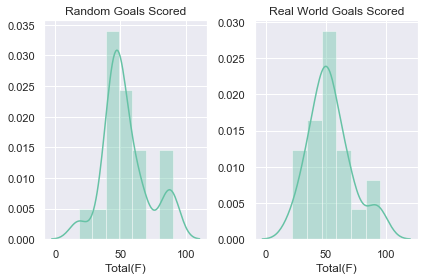

In [55]:
# distibution of randomly generated goals scored at home across the league
plt.subplot(1,2,1)
sns.distplot(total_new["Total(F)"])
plt.title("Random Goals Scored");

# distribution of real world goals scored at home 
plt.subplot(1,2,2)
sns.distplot(total["Total(F)"])
plt.title("Real World Goals Scored");

plt.tight_layout()

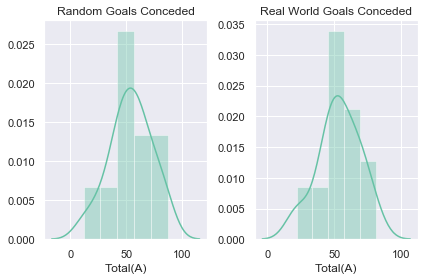

In [56]:
# distibution of randomly generated goals scored at home across the league
plt.subplot(1,2,1)
sns.distplot(total_new["Total(A)"])
plt.title("Random Goals Conceded");

# distribution of real world goals scored at home 
plt.subplot(1,2,2)
sns.distplot(total["Total(A)"])
plt.title("Real World Goals Conceded");

plt.tight_layout()

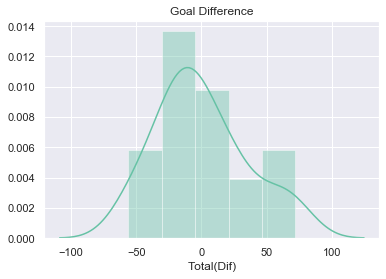

In [57]:
# distribution of goal difference
sns.distplot(total_new["Total(Dif)"])
plt.title("Goal Difference");

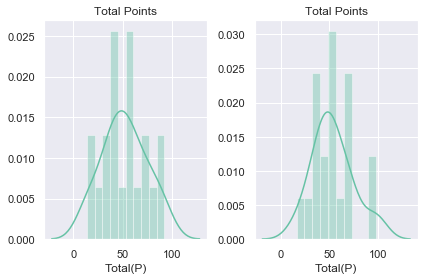

In [58]:
# distribution of randomly generated total points
plt.subplot(1,2,1)
sns.distplot(total_new["Total(P)"], bins = 10)
plt.title("Total Points");

# distribution of real world total points
plt.subplot(1,2,2)
sns.distplot(total["Total(P)"], bins = 10)
plt.title("Total Points");

plt.tight_layout()

In [59]:
# https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/

from scipy.stats import shapiro

stat, p = shapiro(total_new["Total(P)"])

alpha = 0.05

if p > alpha:
    print("Points Distribution appears to be Gaussian")
else:
    print("Points distribution does not appear to be Gaussian")

Points Distribution appears to be Gaussian


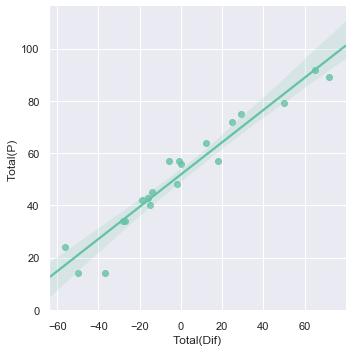

In [63]:
# regression plot between goal difference and total points
sns.lmplot(x="Total(Dif)", y="Total(P)", data=total_new);

## Home vs Away

In [64]:
# created league table based on home form
home_new = pl_new[["Home(F)", "Home(A)", "Home(Dif)", "Points(H)"]]
# sorted league table by points
home_new = home_new.sort_values(by = "Points(H)", ascending=False);
home_new

,Home(F),Home(A),Home(Dif),Points(H)
Team,,,,
Liverpool,57,11,46,55
Manchester City,48,4,44,46
Arsenal,48,10,38,45
Chelsea,46,13,33,42
Wolves,30,12,18,42
Everton,33,22,11,35
Leicester City,27,22,5,34
Manchester United,27,25,2,33
West Ham,24,22,2,32


In [65]:
# description of home dataframe
home_new.describe()

,Home(F),Home(A),Home(Dif),Points(H)
count,20.0000,20.000000,20.000000,20.000000
mean,29.6500,24.300000,5.350000,28.750000
std,11.6134,10.553622,20.029649,13.726176
min,9.0000,4.000000,-19.000000,0.000000
25%,24.0000,19.000000,-8.000000,21.500000
50%,27.0000,24.000000,-2.000000,29.500000
75%,30.7500,31.250000,12.750000,36.750000
max,57.0000,44.000000,46.000000,55.000000


In [66]:
# created league table based on away form
away_new = pl_new[["Away(F)", "Away(A)", "Away(Dif)", "Points(A)"]]
# sorted league table by points
away_new = away_new.sort_values(by="Points(A)", ascending=False);
away_new

,Away(F),Away(A),Away(Dif),Points(A)
Team,,,,
Manchester City,36,8,28,43
Liverpool,33,14,19,37
Everton,35,21,14,37
Arsenal,41,29,12,34
Wolves,30,19,11,33
Crystal Palace,34,27,7,31
Leicester City,28,21,7,30
Newcastle United,23,21,2,26
West Ham,21,24,-3,25


In [67]:
# description of away dataframe
away_new.describe()

,Away(F),Away(A),Away(Dif),Points(A)
count,20.000000,20.000000,20.000000,20.00000
mean,24.300000,29.650000,-5.350000,23.05000
std,8.360937,10.747215,17.886411,10.63992
min,9.000000,8.000000,-42.000000,8.00000
25%,19.500000,21.000000,-15.750000,14.75000
50%,22.500000,29.500000,-8.000000,23.50000
75%,30.750000,35.250000,8.000000,31.50000
max,41.000000,51.000000,28.000000,43.00000


In [68]:
# ordered real world home and away tables by total points to compare with random tables
home = home.sort_values(by = "Points(H)", ascending=False);
away = away.sort_values(by = "Points(A)", ascending=False);

### Goals Scored 

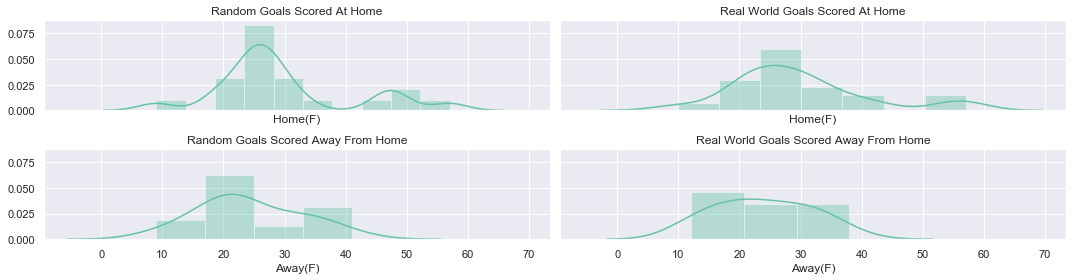

In [69]:
# set up matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(15, 4), sharex=True, sharey=True)

# distribution of randomly generated goals scored at home
sns.distplot(home_new["Home(F)"], ax=axes[0,0])
axes[0,0].set_title("Random Goals Scored At Home");

# distribution of real world goals scored at home
sns.distplot(home["Home(F)"], ax=axes[0,1])
axes[0,1].set_title("Real World Goals Scored At Home");

# distibution of goals scored away from home across the league
sns.distplot(away_new["Away(F)"], ax= axes[1,0])
axes[1,0].set_title("Random Goals Scored Away From Home");

# distibution of goals scored away from home across the league
sns.distplot(away["Away(F)"], ax= axes[1,1])
axes[1,1].set_title("Real World Goals Scored Away From Home");


plt.tight_layout()

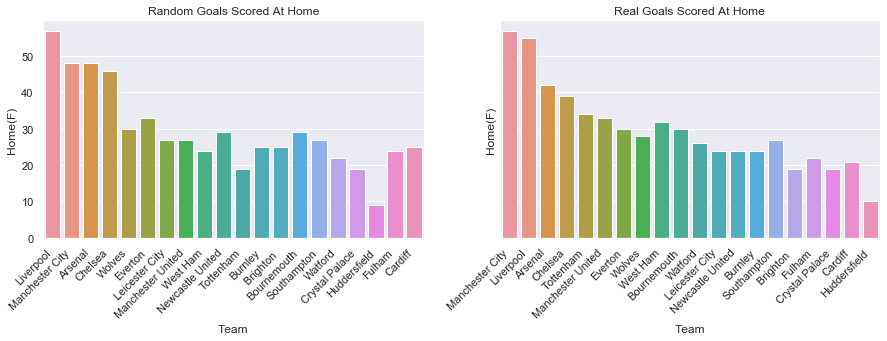

In [70]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# distribution of random goals scored at home
goals_for = sns.catplot(x="Team", y="Home(F)", kind="bar", data=home_new.reset_index(), ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[0].set_title("Random Goals Scored At Home");

# distibution of real goals scored at home 
goals_for = sns.catplot(x="Team", y="Home(F)", kind="bar", data=home.reset_index(), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[1].set_title("Real Goals Scored At Home");

plt.tight_layout()

# closed empty plots
plt.close(2)
plt.close(3)


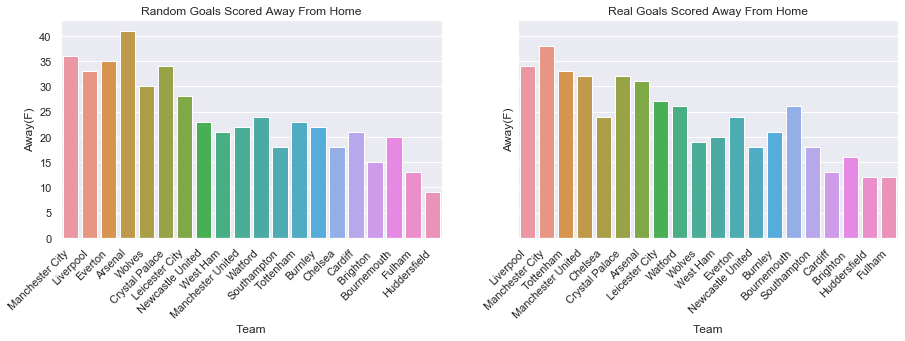

In [71]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# distribution of random goals scored away from home
goals_for = sns.catplot(x="Team", y="Away(F)", kind="bar", data=away_new.reset_index(), ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[0].set_title("Random Goals Scored Away From Home");

# distibution of real goals scored away from home  
goals_for = sns.catplot(x="Team", y="Away(F)", kind="bar", data=away.reset_index(), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[1].set_title("Real Goals Scored Away From Home");

plt.tight_layout()

# closed empty plots
plt.close(2)
plt.close(3)


### Goals Conceded 

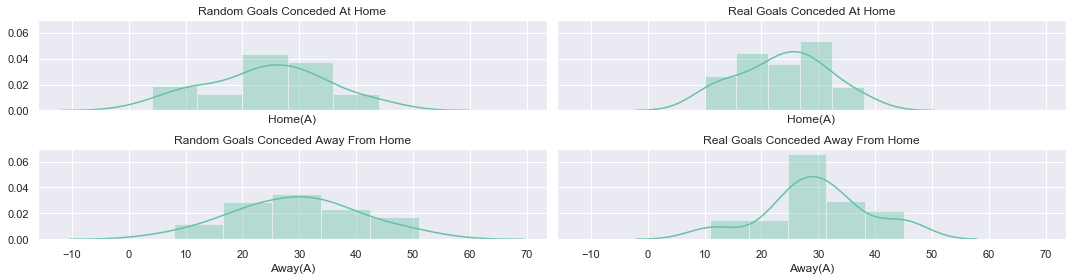

In [72]:
# set up matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(15, 4), sharex=True, sharey=True)

# distribution of randomly generated goals conceded at home
sns.distplot(home_new["Home(A)"], ax=axes[0,0])
axes[0,0].set_title("Random Goals Conceded At Home");

# distribution of real world goals conceded at home
sns.distplot(home["Home(A)"], ax=axes[0,1])
axes[0,1].set_title("Real Goals Conceded At Home");

# distibution of randomly generated goals conceded away from home 
sns.distplot(away_new["Away(A)"], ax= axes[1,0])
axes[1,0].set_title("Random Goals Conceded Away From Home");

# distibution of real generated goals conceded away from home 
sns.distplot(away["Away(A)"], ax= axes[1,1])
axes[1,1].set_title("Real Goals Conceded Away From Home");

plt.tight_layout()

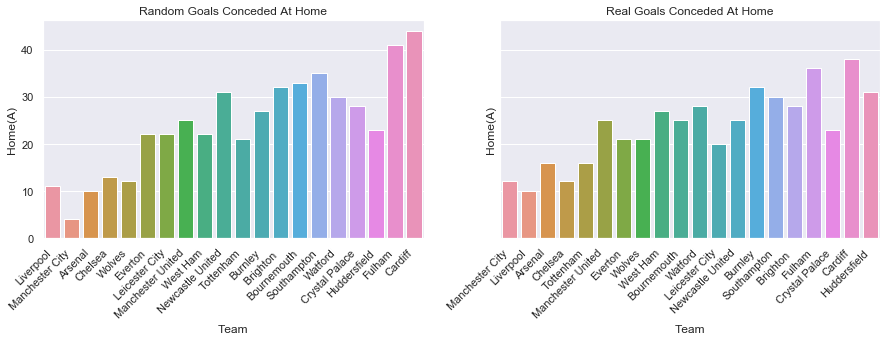

In [73]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# distribution of random goals conceded at home
goals_for = sns.catplot(x="Team", y="Home(A)", kind="bar", data=home_new.reset_index(), ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[0].set_title("Random Goals Conceded At Home");

# distibution of real goals conceded at home 
goals_for = sns.catplot(x="Team", y="Home(A)", kind="bar", data=home.reset_index(), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[1].set_title("Real Goals Conceded At Home");

plt.tight_layout()

# closed empty plots
plt.close(2)
plt.close(3)

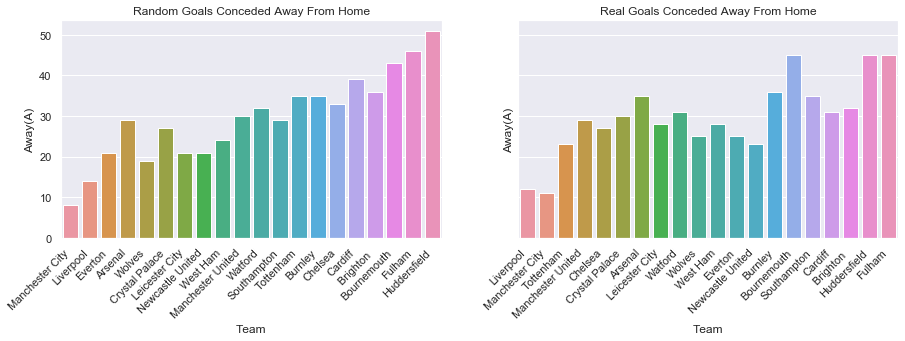

In [74]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# distribution of random goals conceded away from home
goals_for = sns.catplot(x="Team", y="Away(A)", kind="bar", data=away_new.reset_index(), ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[0].set_title("Random Goals Conceded Away From Home");

# distibution of real goals conceded away from home 
goals_for = sns.catplot(x="Team", y="Away(A)", kind="bar", data=away.reset_index(), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[1].set_title("Real Goals Conceded Away From Home");

plt.tight_layout()

# closed empty plots
plt.close(2)
plt.close(3)

### Goal Difference 

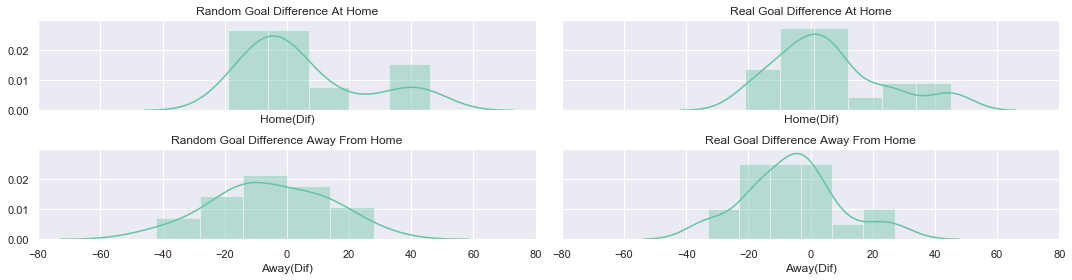

In [75]:
# set up matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(15, 4), sharey=True, sharex=True)

# distribution of randomly goal difference at home
sns.distplot(home_new["Home(Dif)"], ax=axes[0,0])
axes[0,0].set_title("Random Goal Difference At Home");

# distribution of real world goal difference at home
sns.distplot(home["Home(Dif)"], ax=axes[0,1])
axes[0,1].set_title("Real Goal Difference At Home");

# distibution of randomly generated goal difference away from home 
sns.distplot(away_new["Away(Dif)"], ax= axes[1,0])
axes[1,0].set_title("Random Goal Difference Away From Home");

# distibution of real goal difference away from home 
sns.distplot(away["Away(Dif)"], ax= axes[1,1])
axes[1,1].set_title("Real Goal Difference Away From Home");

plt.tight_layout()

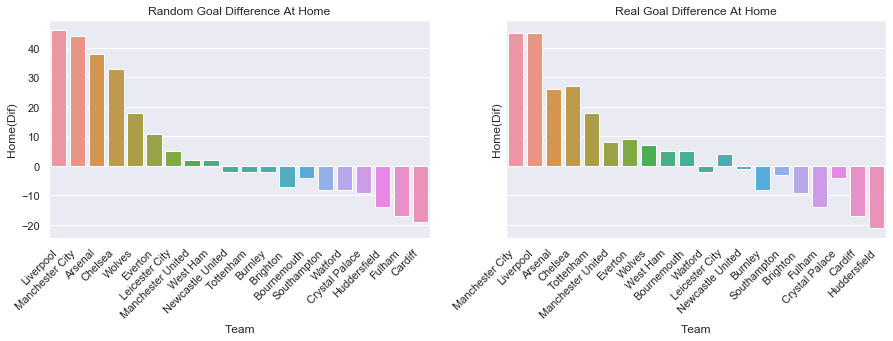

In [76]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# distribution of random goal difference at home
goals_for = sns.catplot(x="Team", y="Home(Dif)", kind="bar", data=home_new.reset_index(), ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[0].set_title("Random Goal Difference At Home");

# distibution of real goal difference at home 
goals_for = sns.catplot(x="Team", y="Home(Dif)", kind="bar", data=home.reset_index(), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[1].set_title("Real Goal Difference At Home");

plt.tight_layout()

# closed empty plots  
plt.close(2)
plt.close(3)

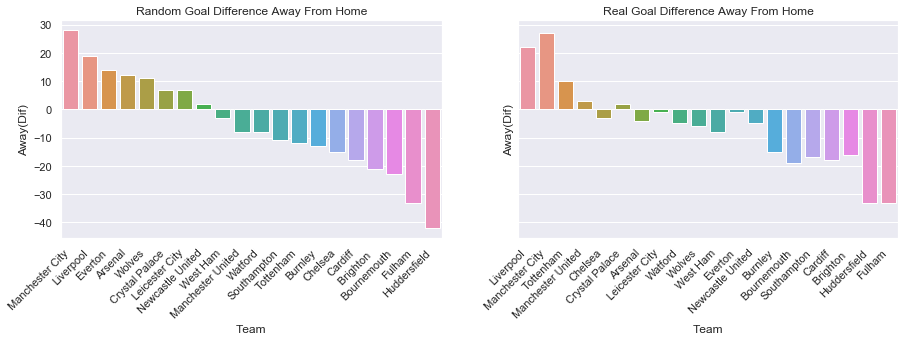

In [77]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# distribution of random goal difference away from home
goals_for = sns.catplot(x="Team", y="Away(Dif)", kind="bar", data=away_new.reset_index(), ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[0].set_title("Random Goal Difference Away From Home");

# distibution of real goal difference away from home 
goals_for = sns.catplot(x="Team", y="Away(Dif)", kind="bar", data=away.reset_index(), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[1].set_title("Real Goal Difference Away From Home");

plt.tight_layout()

# closed empty plots  
plt.close(2)
plt.close(3)

### Points

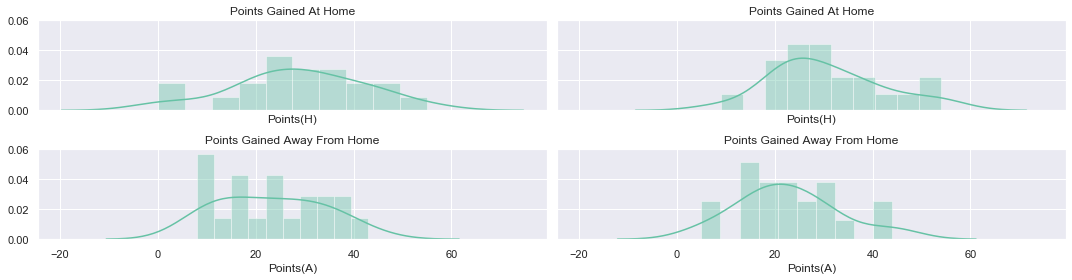

In [78]:
# set up matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(15, 4), sharey=True, sharex=True)

# distribution of randomly generated points gained at home
sns.distplot(home_new["Points(H)"], bins= 10, ax=axes[0,0])
axes[0,0].set_title("Points Gained At Home");

# distribution of real points gained at home
sns.distplot(home["Points(H)"], bins= 10, ax=axes[0,1])
axes[0,1].set_title("Points Gained At Home");

# distibution of randomly generated points gained away from home
sns.distplot(away_new["Points(A)"], bins= 10, ax= axes[1,0])
axes[1,0].set_title("Points Gained Away From Home");

# distibution of real points gained away from home
sns.distplot(away["Points(A)"], bins= 10, ax= axes[1,1])
axes[1,1].set_title("Points Gained Away From Home");

plt.tight_layout()


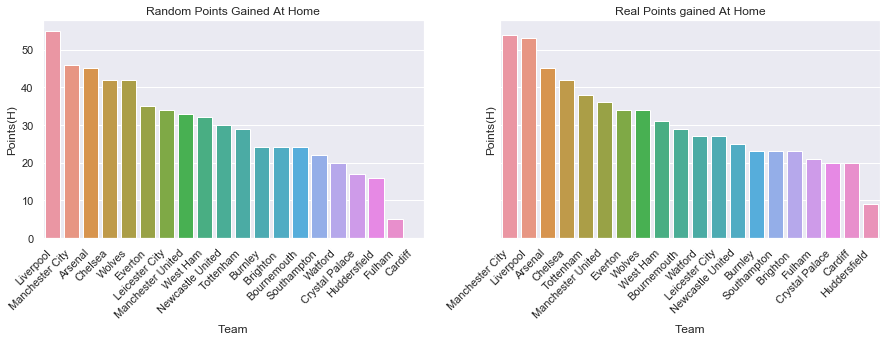

In [79]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# bar plot of random points gained at home
goals_for = sns.catplot(x="Team", y="Points(H)", kind="bar", data=home_new.reset_index(), ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[0].set_title("Random Points Gained At Home");

# bar plot of real points gained at home 
goals_for = sns.catplot(x="Team", y="Points(H)", kind="bar", data=home.reset_index(), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[1].set_title("Real Points gained At Home");

plt.tight_layout()

# closed empty plots
plt.close(2)
plt.close(3)

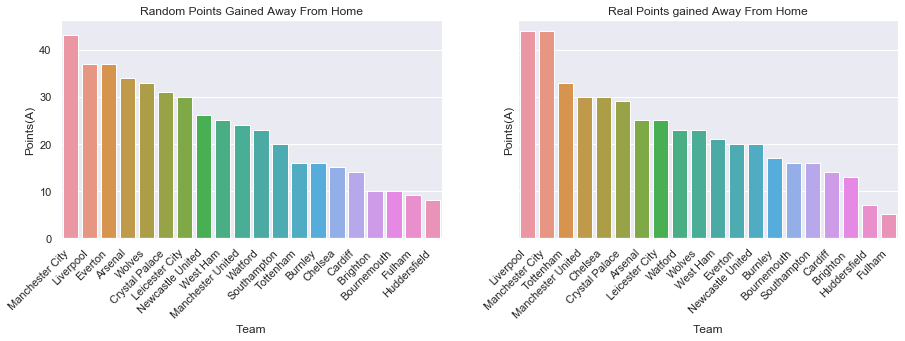

In [80]:
# set up matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# bar plot of random points gained away from  home
goals_for = sns.catplot(x="Team", y="Points(A)", kind="bar", data=away_new.reset_index(), ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[0].set_title("Random Points Gained Away From Home");

# bar plot of real points gained away home 
goals_for = sns.catplot(x="Team", y="Points(A)", kind="bar", data=away.reset_index(), ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment="right")
axes[1].set_title("Real Points gained Away From Home");

plt.tight_layout()

# closed empty plots
plt.close(2)
plt.close(3)

The main purpose of the plots in this section is to demonstrate the relationship between the random data and the real world data. While there is more possibilities for variance in the random data, it shares a number of the characteristics of the real world data. In each plot you can see that the trends are similar, the distribution of goals and score and conceded, at home and away, points earned, goal difference are all in line with the real world data distributions.

Odd quirks of the Premier League table, such as the assertion that teams that gain over 40 points will not finish in the bottom 3 places can be seen when running the python script multiple times; the bottom 3 teams seem to gain points up to the mid thirties at most. Last season a single point seperated Liverpool and Manchester city at the top of the league. Again running the script multiple times shows that invariably one of those two teams finishes in the top position, with there being an occasion surprise team there instead.

In [91]:
%run -i "league.py"
total_ran

Team,Total(F),Total(A),Total(Dif),Total(P)
Manchester City,109,17,92,90
Liverpool,84,17,67,87
Manchester United,71,48,23,73
Tottenham,71,48,23,68
Arsenal,83,60,23,67
Chelsea,59,39,20,66
Leicester City,53,43,10,63
Everton,44,42,2,59
Wolves,45,37,8,56
Newcastle United,45,49,-4,56


In [81]:
pointsDif = pl_new["Points(H)"]/pl_new["Points(A)"]
pointsDif

Team
Huddersfield         2.000000
Fulham               0.555556
Bournemouth          2.400000
Brighton             2.400000
Cardiff              0.000000
Chelsea              2.800000
Burnley              1.500000
Tottenham            1.812500
Southampton          1.100000
Watford              0.869565
Manchester United    1.375000
West Ham             1.280000
Newcastle United     1.153846
Leicester City       1.133333
Crystal Palace       0.548387
Wolves               1.272727
Arsenal              1.323529
Everton              0.945946
Liverpool            1.486486
Manchester City      1.069767
dtype: float64